In [1]:
import numpy as np
from PIL import Image
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
import cv2

In [2]:
kernel_code = """
__global__ void grayscale_conversion(unsigned char *Pin, unsigned char *Pout, int width, int height) {
    int Col = blockIdx.x * blockDim.x + threadIdx.x;
    int Row = blockIdx.y * blockDim.y + threadIdx.y;

    if (Col < width && Row < height) {
        int grayOffset = Row*width + Col;
        int rgbOffset = grayOffset * 3;
        unsigned char r = Pin[rgbOffset];
        unsigned char g = Pin[rgbOffset + 1];
        unsigned char b = Pin[rgbOffset + 2];
        unsigned char L = 0.21f * r + 0.71f * g + 0.07f * b;
        Pout[grayOffset] = L;
    }
}
"""

In [3]:
image_path = "../img/billie.jpg"
image = Image.open(image_path)
width, height = image.size

In [4]:
image_array = np.array(image, dtype=np.uint8)

In [5]:
image_in_gpu = cuda.mem_alloc(image_array.nbytes)
image_out_gpu = cuda.mem_alloc(width * height)
cuda.memcpy_htod(image_in_gpu, image_array)

In [6]:
mod = SourceModule(kernel_code)
grayscale_conversion = mod.get_function("grayscale_conversion")

In [7]:
block_dim = (16, 16, 1)
grid_dim = ((width + block_dim[0] - 1) // block_dim[0], (height + block_dim[1] - 1) // block_dim[1])

In [8]:
grayscale_conversion(
        image_in_gpu,
        image_out_gpu,
        np.int32(width),
        np.int32(height),
        block=block_dim,
        grid=grid_dim)

In [9]:
image_out = np.empty_like(image_array[:, :, 0])

In [10]:
cuda.memcpy_dtoh(image_out, image_out_gpu)

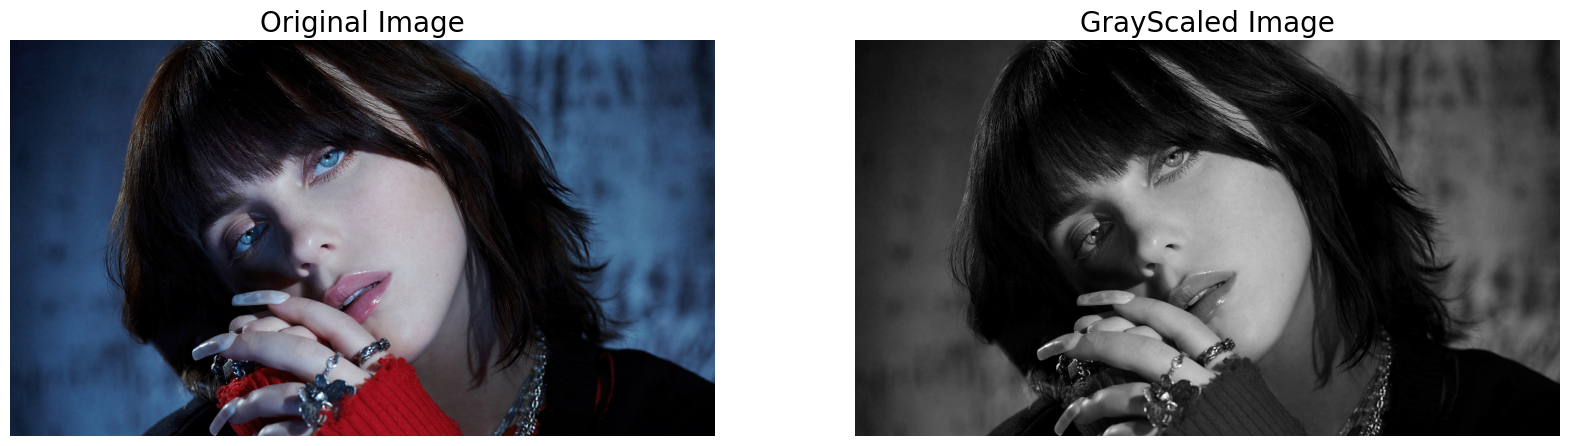

In [11]:
plt.figure(figsize=(20, 14))

plt.subplot(1, 2, 1)
plt.title("Original Image", size = 20)
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("GrayScaled Image", size = 20)
plt.imshow(cv2.cvtColor(image_out, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

In [12]:
image_array.shape

(4320, 7680, 3)

In [13]:
del image_in_gpu
del image_out_gpu